# Example Analysis of Jupyter Notebooks on Github
*Adam Rule - February 5, 2018*

In July 2017, we downloaded and analyzed nearly all of the Jupyter Notebooks in public repositories on Github. In total, this dataset includes:
* ~1.25 million Jupyter Notebooks
* metadata about each of these notebooks
* metadata about each of the nearly 200,000 repositories that contained a Jupyter Notebook
* top level README files for the nearly 150,000 repositiories with such a file

As an introduction to this dataset, we have created a smaller sample dataset including data about 1000 randomly sampled repositories and the roughtly 6000 notebooks they contain. This notebook demonstrates how to perform a couple simple analyses with this sample dataset. 

For more information about the full dataset please see the [data repository at UC San Diego Library's Digital Collections](https://doi.org/10.6075/J0JW8C39).

For more information about our initial analysis of this dataset, please see our paper [Exploration and Explanaion in Computational Notebooks](https://doi.org/10.1145/3173574.3173606) to be published at CHI 2018. If the above DOI link is not active yet, see our [draft version of the paper](http://adamrule.com/files/papers/chi_2018_computational_notebooks_final_web.pdf).

## Imports and Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

%matplotlib inline

In [2]:
df_nb = pd.read_csv('../data/csv/notebooks_sample.csv')
df_repo = pd.read_csv('../data/csv/repositories_sample.csv')
df_readme = pd.read_csv('../data/csv/readmes_sample.csv')

print('%s sample notebooks' % df_nb.shape[0])
print('%s sample repositiores' % df_repo.shape[0])
print('%s sample readmes' % df_readme.shape[0])

6529 sample notebooks
1000 sample repositiores
750 sample readmes


## A Word about Data

You may notice that we are starting by loading three files from the `csv` folder. These files summarize data that was downloaded from Github. However the raw data lives in four other folders: `notebook_metadata`, `notebooks`, `repository_metadata`, and `readmes`. We describe these data in more detail elsewhere in the data repository, but in short they include:

**Notebook Metadata** - Each JSON file in this folder is the result of a query to Github asking for all the Jupyter Notebooks within a certain range of byte sizes (e.g. 0 to 10 bytes). We had to subdivide this query by byte size because Github will only return up to 1000 results at a time. Github further paginates results into pages with up to 100 results each. Therefore, a query returning 977 results would be broken up into ten different pages, the first nine with 100 results each and the last with 77 results. Each file name includes the byte size and page number of the results it contains. Most of the relevant data from these files are summarized in the `notebooks_sample.csv` file.

**Notebooks** - Each ipynb file in this folder was downloaded directly from Github using the url listed in `notebooks_sample.csv`. The files are named based on of the `nb_id` we assigned to each notebook in `notebooks_sample.csv`.

**Repository Metadata** - Each JSON file in this folder is Github's response to a query for metadata relating to a repository that included a notebook in our dataset. Each file is named using a repository id that Github assigns. This data is summarized in `repositories_sample.csv`, however, the raw JSON files include more information such as how many times the repository had been forked, stared, or watched.

**Readmes** - Each JSON file in this folder is Github's response to a query for the top level README file associated with a repository containing a Jupyter Notebook. Some of these JSON files may be empty if there was not a README file in the repository's top directory. Each JSON file is named using the unique id that Github assigns each repository. This README data, including the content of each README file, is summarized in `readmes_sample.csv`. Note that the README content is Base64 encoded in the CSV and JSON files.

## How many notebooks per repository?

One high level question we might want to ask is how many notebooks there are each repository. Are most notebooks singletons, living in a repostiory by themselves, or do most live in repositories with other notebook files? In this case, we can answer this question using data found in the `notebooks.csv` file, now as the dataframe `df_nb`.

Text(0, 0.5, '# Repositories')

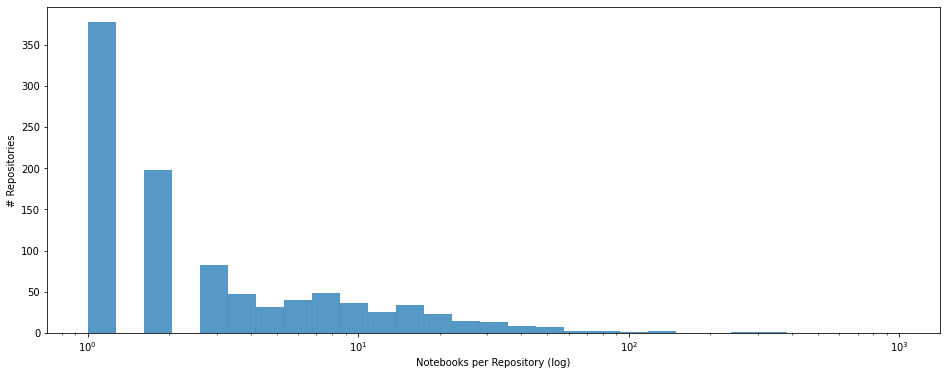

In [5]:
plt.figure(figsize=(16,6))
repo_counts = df_nb.repo_id.value_counts()

ax = sns.histplot(repo_counts, kde=False, bins = np.logspace(0,3,30))
ax.set_xscale('log')
ax.set_xlabel('Notebooks per Repository (log)')
ax.set_ylabel('# Repositories')

From this log plot, it looks like a little over 1/3 of repositories only have one notebook file in them (10^0), but most have more than one, and some have hundreds.

## What are these repositories about?

Another question we may want to ask is what are these repositories about? Are they mostly machine learning analyses? Or or do some analyze genomic data? There are many ways to answer this question including using natural language processing to identify keywords in the notebooks. A simpler analysis (which will not require downloading the `nltk` Python package) would be to look at the descriptions of each repository by hand. We will use this trivial analysis to demonstrate scraping additional data from the raw repository metadata JSON files we downloaded from Github.

In [6]:
def get_description(repo_id):
    repo_meta_name = '../data/repository_metadata/repo_' + str(repo_id) + '.json'
    
    with open(repo_meta_name) as meta_file:
        try:
            data = json.load(meta_file)
            return data['description']
        except:
            return None
        
df_repo['description'] = df_repo['repo_id'].apply(get_description)

Now we can look at the first 20 descriptions to get a sense for what the repositories are about. 

Note the diversity of topics (perception, banking fraud, NYC subway data). Also note that many repositories seem to be associated with course projects (BioCoding 2015, Stanford cs231n)

In [7]:
df_repo['description'][0:20]

0                     Interactive Python book exercises
1                  Coursework for BioCoding 2015 Course
2                                                  None
3     an evolving approach for writing Jupyter/IPyth...
4                   IMPLEMENTING A PERCEPTRON ALGORITHM
5     Identifying fraudulent transactions and bankno...
6                                                  None
7                             Analyzing NYC subway data
8     spherical-harmonics-expansion using boost and gsl
9                                                  None
10                                      Stanford cs231n
11    IPython notebook that uses Boto, Pandas and Ma...
12    ZipPy is a Python3 interpreter on top of Truff...
13               Probabilistic Robotics Test Repository
14                                                 None
15                                                 None
16                                                 None
17    My solution to the Boston housing prices p

## How many cells per notebook?

Many analyses will require parsing notebook contents to calculate features such as the libraries each notebook imports, or how many functions each notebook defines. As a simple example of this type of analysis, we will calculate the number of cells in each notebook. Note that despite the `.ipynb` extextion, Jupyter Notebooks are plain JSON files. This makes them relatively easy to analyze, with one catch. The [nbformat](https://nbformat.readthedocs.io/en/latest/) that defines how this JSON object is structured has changed over time. For example, older versions of the notebook stored cells under "worksheets" rather than at the top level of the file.

In [8]:
def get_num_cells(nb_id):
    
    nb_name = '../data/notebooks/nb_' + str(nb_id) + '.ipynb'
    
    with open(nb_name) as nb_file:
        
        try:
            # get the nb as a JSON file
            data = json.load(nb_file)
            if isinstance(data, dict): 
                keys = data.keys()
            else:
                keys = []
            
            # get the number of cells
            if 'cells' in keys:
                return len(data['cells'])
            elif 'worksheets' in keys:
                num_cells = 0
                for w in data['worksheets']:
                    num_cells += len(w['cells'])
                return num_cells
        
        except:
            return None
        
        
df_nb['num_cells'] = df_nb['nb_id'].apply(get_num_cells)

In [9]:
df_nb['num_cells'][0:10]

0      NaN
1      NaN
2      NaN
3     45.0
4     44.0
5     16.0
6     31.0
7    141.0
8     13.0
9      9.0
Name: num_cells, dtype: float64

It seems like we are missing some data. Are these just bugs in our code, or do the notebooks really not have any cells? Let's take a closer look.

In [11]:
df_nb.head()

,nb_id,html_url,max_filesize,min_filesize,name,path,query_page,repo_id,num_cells
0,294,https://github.com/j3hempsey/dotfiles/blob/f3e...,10,0,jupyter.ipynb,atom/packages/file-icons/examples/jupyter.ipynb,3,33378844,NaN
1,329,https://github.com/cagdasyetkin/raspberryPi3/b...,10,0,IoTdemo.ipynb,IoTdemo.ipynb,4,89953189,NaN
2,580,https://github.com/Ruijin1988/Material-Design-...,10,0,6_Artistic_style_transfer_with_a_repurposed_VG...,vanilla_vae/6_Artistic_style_transfer_with_a_r...,6,90590288,NaN
3,594,https://github.com/psygrammer/dprl/blob/c4bdd2...,1000000000,100000000,Design_1.ipynb,part2/OT/3.Result/Design_1.ipynb,1,40293216,45.0
4,921,https://github.com/ArtemKupriyanov/MOOC-COURSE...,10025,10005,sklearn.datasets-2.ipynb,ML-MIPT-Yandex-spec/2.supervised_learning/Trai...,4,74897953,44.0


These first three NaN's make sense. The file sizes are very small (between 0-10 bytes) so it is likely that these are just empty files that have the .ipynb extension. Note that working with this dataset will require ongoing cleaning depending on what question you are trying to answer. For now, let's replace the NaN's with 0 and look at notebook length.

Text(0, 0.5, '# Notebooks')

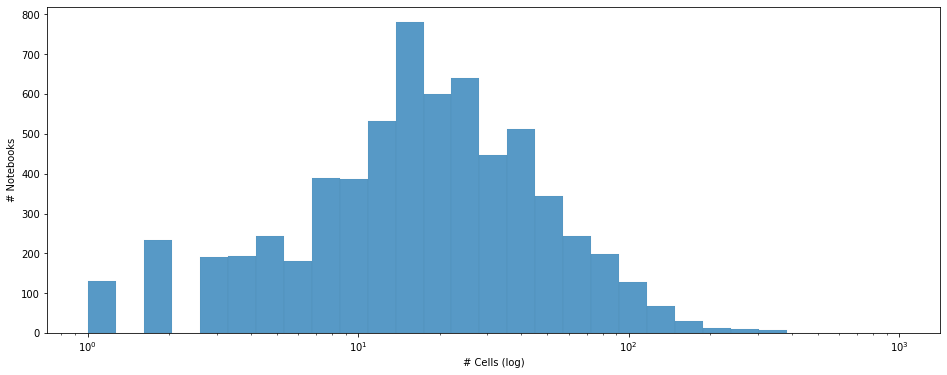

In [13]:
df_nb.num_cells.fillna(0, inplace=True)
plt.figure(figsize=(16,6))

ax = sns.histplot(df_nb.num_cells, kde=False, bins = np.logspace(0,3,30))
ax.set_xscale('log')
ax.set_xlabel('# Cells (log)')
ax.set_ylabel('# Notebooks')

# Conclusion

We hope these examples are enough to get you started with using the dataset. For more examples of the kinds of analysis you can perform, see our analysis notebook in the main data repository.